<a href="https://colab.research.google.com/github/diegoturenne/Application-Oriented-Deep-Learning-Course-2022-UU/blob/main/Exercise_10_real_time_noise_rejection_DT_FD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np

from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, GlobalAveragePooling1D, Activation, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D

You can estimate how fast a network prediction can be calculated by calculating the number of floating point operations performed in the network. This package is a handy tool to do it. Use it like this `print(get_flops(my_model))` where `my_model` is your KERAS neural network model. 

In [ ]:
!pip install keras-flops
from keras_flops import get_flops

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Downloading the data (1 signal data file and 5 noise data files)

In [ ]:
# download data file that contains signal events
!gdown https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq


Downloading...
From: https://drive.google.com/uc?id=1t-1icmiJ8Nwu1dm_USIc_W13B68QDwqq
To: /content/trimmed100_data_signal_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 188MB/s]


In [ ]:
# download data file that contains noise events
!gdown https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
!gdown https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
!gdown https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
!gdown https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
!gdown https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY

Downloading...
From: https://drive.google.com/uc?id=14Aff8wf-e1qTQwWU0I-PkrbdbdtS6dei
To: /content/trimmed100_data_noise_3.6SNR_1ch_0000.npy
100% 80.0M/80.0M [00:00<00:00, 218MB/s]
Downloading...
From: https://drive.google.com/uc?id=1EkhWgOXOvaK74JiWPOxt6DUE4S5NGYrT
To: /content/trimmed100_data_noise_3.6SNR_1ch_0001.npy
100% 80.0M/80.0M [00:00<00:00, 128MB/s]
Downloading...
From: https://drive.google.com/uc?id=1BSPvbNOJ2kG7p3ImsVekz4jwXUqlhLRd
To: /content/trimmed100_data_noise_3.6SNR_1ch_0002.npy
100% 80.0M/80.0M [00:00<00:00, 131MB/s]
Downloading...
From: https://drive.google.com/uc?id=1xoTjcJd762XUAP0I7Ukv0y2go6ZwTmIa
To: /content/trimmed100_data_noise_3.6SNR_1ch_0003.npy
100% 80.0M/80.0M [00:00<00:00, 155MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CAmatsbjLmhefxvoH4fr7O-8pGA5p4KY
To: /content/trimmed100_data_noise_3.6SNR_1ch_0004.npy
100% 80.0M/80.0M [00:00<00:00, 148MB/s]


Load the data into memory and combine it into one array. 

In [ ]:
# load signal and noise data set into memory
noise = np.load("trimmed100_data_noise_3.6SNR_1ch_0000.npy")
for i in range(1,5):
  noise = np.vstack((noise,np.load(f"trimmed100_data_noise_3.6SNR_1ch_000{i}.npy")))
signal = np.load("trimmed100_data_signal_3.6SNR_1ch_0000.npy")
n_classes = 2

In [ ]:
# combine noise and signal data set
x = np.vstack((noise, signal))
print(x.shape)
# in case you want to train a CNN, you need to add an empty dimension to the array
# which you can do via x = np.expand_dims(x, axis=-1)  

# define labels. As we have only two categories, we don't use one-hot encoding
# but can just use "0" for noise and "1" for signal. 
y = np.ones(len(x))
y[:len(noise)] = 0

(599997, 100)


Currently, the training data first contains all noise events and then only signal events. This is not optimal, especially because Keras will pick the last X% of the data set for the validation data (which would mean we train only on noise and then validate with signal, which does not make much sense). Therefore, we randomly shuffle the dataset. Important: The x and y arrays need to be shuffled identicially as in the code below. 

In [ ]:
# shuffel the data
shuffle = np.arange(x.shape[0], dtype=np.int)
np.random.shuffle(shuffle)
x = x[shuffle]
y = y[shuffle]
# sorry we read later that we shouldn't have created an independent test set and now we kind of want to keep it 
x_test = x[-60000:]
y_test = y[-60000:]

x = x[:-60000]
y = y[:-60000]

# to still be able to identify the signal events you can do
smask = y == 1
# then you can get all signal events via `x[smask]`
# and all noise events via `x[~smask]`


<ipython-input-7-ebf362ee4f93>:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  shuffle = np.arange(x.shape[0], dtype=np.int)


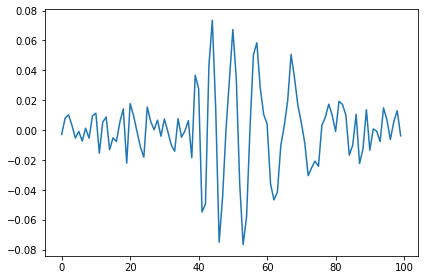

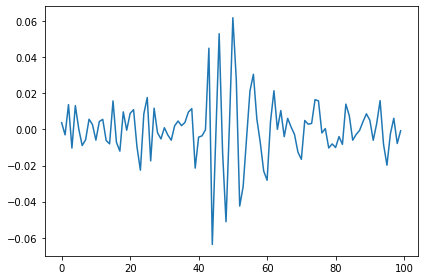

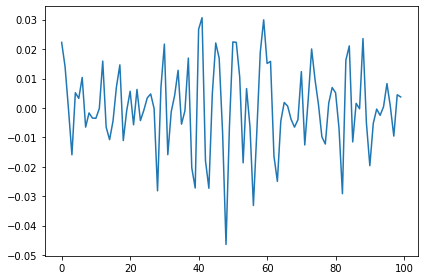

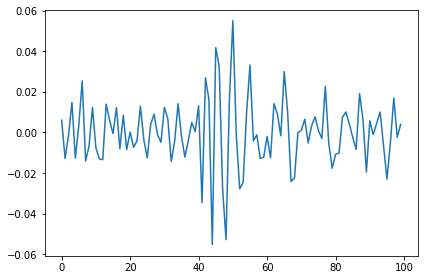

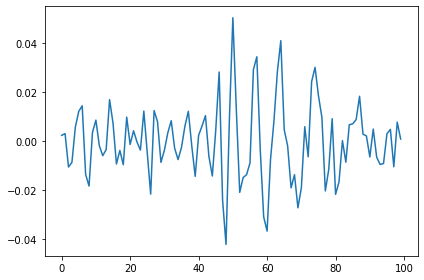

In [ ]:
# plot a few signal events
for trace in x[smask][:5]:
  fig, ax = plt.subplots(1, 1)
  ax.plot(trace,)
  fig.tight_layout()
  # plt.legend()
  plt.show()

In [ ]:
from tensorflow.keras import layers
import tensorflow as tf


In [ ]:
# model = Sequential([
#     layers.Conv1D(100, kernel_size=4, padding="same", activation="relu", input_shape=(100, 1)),
#     layers.Dropout(0.4),
#     layers.Conv1D(50, kernel_size=4, padding="same", activation="relu",),
#     layers.Dropout(0.4),
#     layers.Flatten( ) ,
#     layers.Dense(50, activation = 'relu', ),#input_shape=(100, 1) ), # part of the optimisation: took the heaviest layer away. still reaches quite goof accuracy 
#     layers.Dropout(0.4),
#     layers.Dense(10, activation = 'relu' ),
#     layers.Dropout(0.4),
#     layers.Dense(1, activation="sigmoid" )
#     ],
#     name="nn",
#     )

# print(model.summary())
# print('\n ')
# print('nb of flops:')
# print(get_flops(model))

In [ ]:
model = Sequential()
model.add(Conv1D(5, kernel_size=4, activation='relu', input_shape=(100, 1)))  # n_filters, n_width
model.add(Dropout(0.5))
model.add(MaxPooling1D(pool_size=10))
model.add(Flatten())  
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 97, 5)             25        
                                                                 
 dropout (Dropout)           (None, 97, 5)             0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 9, 5)             0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 45)                0         
                                                                 
 dense (Dense)               (None, 1)                 46        
                                                                 
Total params: 71
Trainable params: 71
Non-trainable params: 0
____________________________________________________________

In [ ]:
print(get_flops(model))

Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`


4906


In [ ]:
# ----------------------------------------------------------
# Training
# ----------------------------------------------------------
model.compile(
    loss="binary_crossentropy",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
    metrics=["accuracy"],
)

model.fit(
    x,
    y,
    batch_size=32,
    epochs=50,
    validation_split = 0.2,
    callbacks=[tf.keras.callbacks.CSVLogger("history_{}.csv".format(model.name))],
    )

Epoch 1/50
13500/13500 [==============================] - 59s 4ms/step - loss: 0.1703 - accuracy: 0.9381 - val_loss: 0.2300 - val_accuracy: 0.9808
Epoch 2/50
13500/13500 [==============================] - 65s 5ms/step - loss: 0.0663 - accuracy: 0.9800 - val_loss: 0.2185 - val_accuracy: 0.9609
Epoch 3/50
13500/13500 [==============================] - 70s 5ms/step - loss: 0.0579 - accuracy: 0.9826 - val_loss: 0.2232 - val_accuracy: 0.9485
Epoch 4/50
13500/13500 [==============================] - 68s 5ms/step - loss: 0.0551 - accuracy: 0.9835 - val_loss: 0.2384 - val_accuracy: 0.9350
Epoch 5/50
13500/13500 [==============================] - 65s 5ms/step - loss: 0.0540 - accuracy: 0.9838 - val_loss: 0.1754 - val_accuracy: 0.9650
Epoch 6/50
13500/13500 [==============================] - 65s 5ms/step - loss: 0.0531 - accuracy: 0.9839 - val_loss: 0.2142 - val_accuracy: 0.9439
Epoch 7/50
13500/13500 [==============================] - 63s 5ms/step - loss: 0.0526 - accuracy: 0.9842 - val_loss: 0

In [ ]:
#  still rejecting 99.9% noise events and keeping a 90% signal efficiency

In [ ]:
y_predict = model.predict(x_test, batch_size=256)
# y_predict = model.predict(x, batch_size=256)

235/235 [==============================] - 1s 6ms/step


The efficiency ( or sensitivity) is defined as : 

$E_A  = \frac{N_{A}^{true}}{N_{A}^{total}}$

Where $N_{A}^{true}$ is the number of true positives and $N_{A}^{total}$ definied as $N_{A}^{true} + N_{not A}^{false}$. 

$N_{not A}^{false}$ nb of events predicted not to be A which are in reality A

I will add a treshold cut value on top of the sigmoid result to cut off at a ceratin probalility, this will give different noise and efficiency rates: again: the definitions 

In [ ]:
y_test.shape 

(60000,)

In [ ]:
# y_predict_tresh.shape

In [ ]:
tresh_list = np.arange(0.001, 0.99, 1e-3)
effi_list = np.zeros_like(tresh_list)
noise_reject_list = np.zeros_like(tresh_list)

for i, tresh in enumerate(tresh_list): 
  y_predict_tresh = np.where(y_predict > tresh, 1, 0)
  N_A_true = ((y_test == 1)&(y_predict_tresh == 1).flatten()).sum()
  N_not_A_false = ((y_test == 0)&(y_predict_tresh == 1).flatten()).sum()
  N_A_total = N_A_true + N_not_A_false

  # for the noise rejection rate: 

  N_noise_true = ((y_test == 0)&(y_predict_tresh == 0).flatten()).sum() # number of events predicted to be noise that are actually noise
  N_not_noise_false = ((y_test == 1)&(y_predict_tresh == 0).flatten()).sum()
  N_noise_total = N_noise_true +  N_not_noise_false

  effi = 100 * N_A_true/N_A_total
  noise_reject = 100 * N_noise_true/N_noise_total

  effi_list[i] = effi
  noise_reject_list[i] = noise_reject

# print(f' the signal efficiency is: {100 * N_A_true/N_A_total} %')
# print(f' noise rejection is at: {100 * N_noise_true/N_noise} %')

<ipython-input-19-5a1149e79dea>:18: RuntimeWarning: invalid value encountered in long_scalars
  noise_reject = 100 * N_noise_true/N_noise_total


Text(0.5, 1.0, 'Almost ')

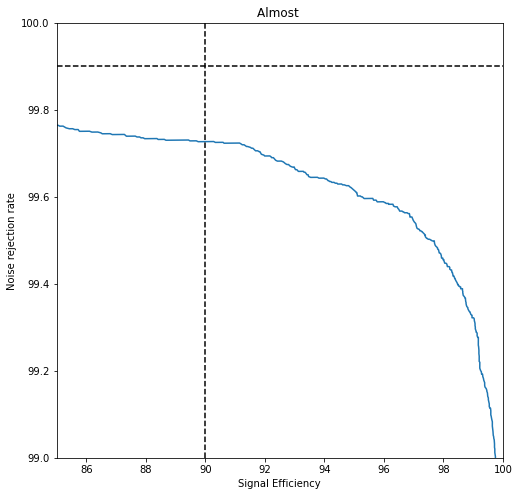

In [ ]:
plt.figure(facecolor = 'white', figsize = (8,8))
plt.plot(effi_list,noise_reject_list, '-')
plt.xlabel('Signal Efficiency')
plt.ylabel('Noise rejection rate')
plt.ylim(99, 100)
plt.xlim(85, 100)
plt.axhline(99.9, ls = '--', c= 'k')
plt.axvline(90, ls = '--', c= 'k')
plt.title('Almost ')

# Previous Architecture with the right precision

Text(0.5, 1.0, 'Almost ')

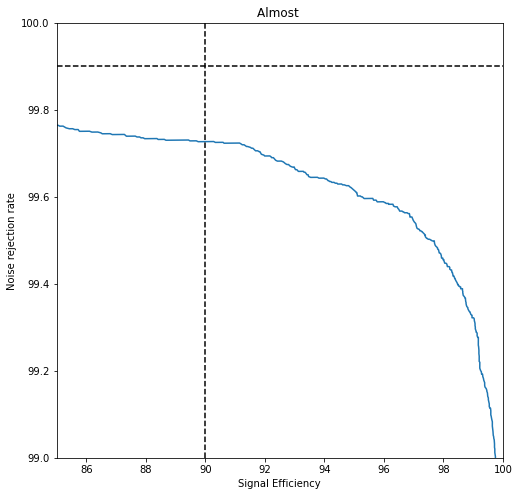

In [ ]:
plt.figure(facecolor = 'white', figsize = (8,8))
plt.plot(effi_list,noise_reject_list, '-')
plt.xlabel('Signal Efficiency')
plt.ylabel('Noise rejection rate')
plt.ylim(99, 100)
plt.xlim(85, 100)
plt.axhline(99.9, ls = '--', c= 'k')
plt.axvline(90, ls = '--', c= 'k')
plt.title('Almost ')

Text(0.5, 1.0, 'DONE !')

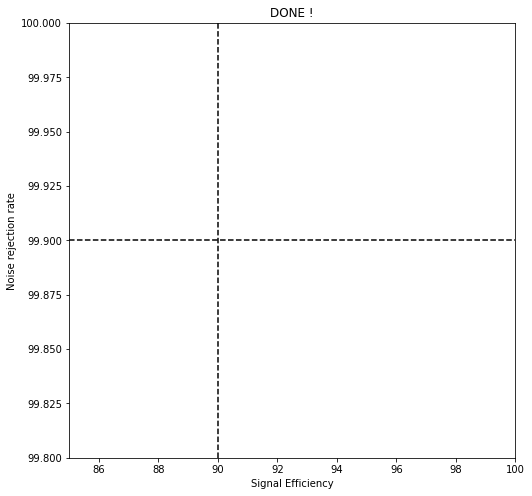

In [ ]:
plt.figure(facecolor = 'white', figsize = (8,8))
plt.plot(effi_list,noise_reject_list, '-')
plt.xlabel('Signal Efficiency')
plt.ylabel('Noise rejection rate')
plt.ylim(99.8,100 )
plt.xlim(85, 100)
plt.axhline(99.9, ls = '--', c= 'k')
plt.axvline(90, ls = '--', c= 'k')
plt.title('DONE !')

In [ ]:
tresh_list

array([0.01])

Text(0.5, 1.0, 'Poor Architecure example: no point in the treshhold is on the top right of the requirements.')

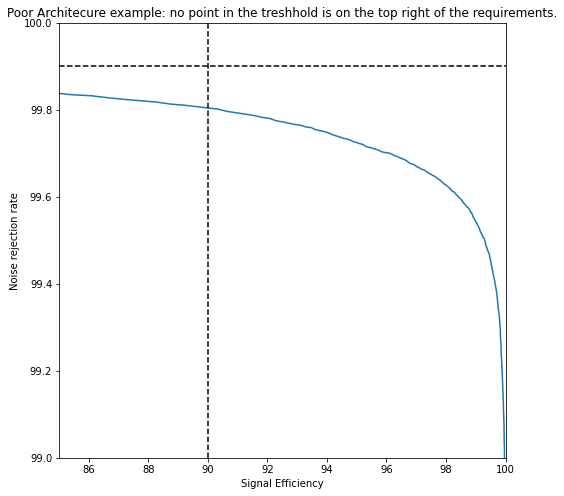

In [ ]:

plt.figure(facecolor = 'white', figsize = (8,8))
plt.plot(effi_list,noise_reject_list, '-')
plt.xlabel('Signal Efficiency')
plt.ylabel('Noise rejection rate')
plt.ylim(99, 100)
plt.xlim(85, 100)
plt.axhline(99.9, ls = '--', c= 'k')
plt.axvline(90, ls = '--', c= 'k')
plt.title('Poor Architecure example: no point in the treshhold is on the top right of the requirements.')

Text(0.5, 1.0, 'better, but Nope! ')

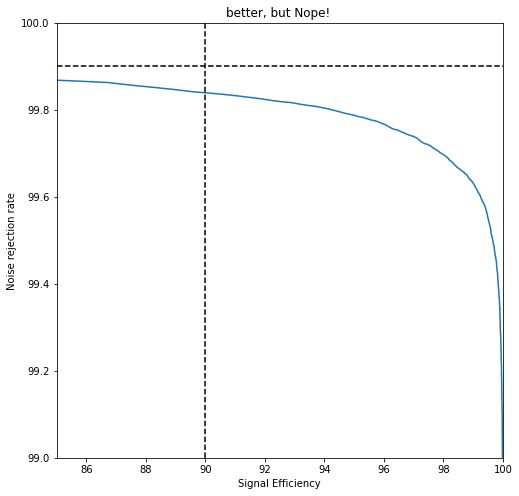

In [ ]:
plt.figure(facecolor = 'white', figsize = (8,8))
plt.plot(effi_list,noise_reject_list, '-')
plt.xlabel('Signal Efficiency')
plt.ylabel('Noise rejection rate')
plt.ylim(99, 100)
plt.xlim(85, 100)
plt.axhline(99.9, ls = '--', c= 'k')
plt.axvline(90, ls = '--', c= 'k')
plt.title('better, but Nope !')

Text(0.5, 1.0, 'Almost ')

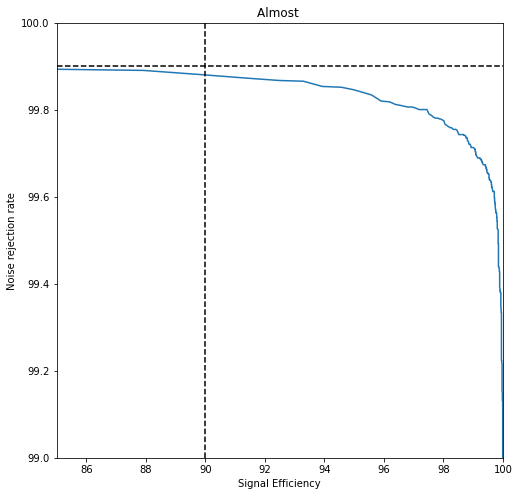

In [ ]:
plt.figure(facecolor = 'white', figsize = (8,8))
plt.plot(effi_list,noise_reject_list, '-')
plt.xlabel('Signal Efficiency')
plt.ylabel('Noise rejection rate')
plt.ylim(99, 100)
plt.xlim(85, 100)
plt.axhline(99.9, ls = '--', c= 'k')
plt.axvline(90, ls = '--', c= 'k')
plt.title('Almost ')